# W-net Model - Train

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys
from keras.optimizers import  Adam

# Importing our w-net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import frequency_spatial_network as fsnet

# Importing callbacks and data augmentation utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

/home/roberto/Documents/virtualenv/venv04/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Train Set 
train_path = "/media/roberto/DATA/GDrive/MR-Data/Normative-Raw-Data/Train/*.npy"
kspace_files_train = np.asarray(glob.glob(train_path))

# Validation set
val_path = "/media/roberto/DATA/GDrive/MR-Data/Normative-Raw-Data/Val/*.npy"
kspace_files_val = np.asarray(glob.glob(val_path))

indexes = np.arange(kspace_files_train.size,dtype = int)
np.random.shuffle(indexes)
kspace_files_train = kspace_files_train[indexes]


print kspace_files_train[-1]
print len(kspace_files_train)
print 
print kspace_files_val[-1]
print len(kspace_files_val)

/media/roberto/DATA/GDrive/MR-Data/Normative-Raw-Data/Train/e14140s3_P52224.7.npy
25

/media/roberto/DATA/GDrive/MR-Data/Normative-Raw-Data/Val/e14553s5_P44544.7.npy
10


Undersampling: 0.822937011719
Mask type: bool


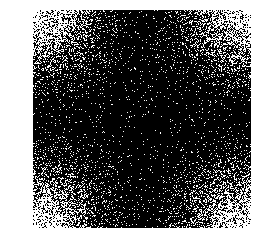

In [3]:
under_rate = '20'
imshape = (256,256)
norm = np.sqrt(imshape[0]*imshape[1])
nchannels = 2 #complex data real + imag

# undersampling patterns - uncentred k-space
var_sampling_mask = np.load("../Data/sampling_mask_" + under_rate + "perc.npy")

print "Undersampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size
print "Mask type:",  var_sampling_mask.dtype
plt.figure()
plt.imshow(~var_sampling_mask,cmap = "gray")
plt.axis("off")
plt.show()

## Load Train Data

In [4]:
# Get number of samples
ntrain = 0
for ii in xrange(len(kspace_files_train)):
    ntrain += np.load(kspace_files_train[ii]).shape[0]

# Load train data    
rec_train = np.zeros((ntrain,imshape[0],imshape[1],2))
kspace_train = np.zeros((ntrain,imshape[0],imshape[1],2))
aux_counter = 0
for ii in xrange(len(kspace_files_train)):
     aux_kspace = np.load(kspace_files_train[ii])/norm
     aux = aux_kspace.shape[0]   
     aux2 = np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1])
     rec_train[aux_counter:aux_counter+aux,:,:,0] = aux2.real
     rec_train[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
     kspace_train[aux_counter:aux_counter+aux,:,:,0] = aux_kspace[:,:,:,0]
     kspace_train[aux_counter:aux_counter+aux,:,:,1] = aux_kspace[:,:,:,1]
     aux_counter+=aux

# Shuffle training    
indexes = np.arange(rec_train.shape[0],dtype = int)
np.random.shuffle(indexes)
rec_train = rec_train[indexes]

kspace_train[:,var_sampling_mask,:] = 0 # undersample k-space

# save k-space and image domain stats
stats = np.zeros(4)
stats[0] = kspace_train.mean()
stats[1] = kspace_train.std()
aux = np.abs(rec_train[:,:,:,0] +1j*rec_train[:,:,:,1])
stats[2] = aux.mean()
stats[3] = aux.std()
np.save("../Data/stats_fs_unet_norm_" + under_rate + ".npy",stats)

print "Number of training samples", rec_train.shape[0]
kspace_train = 0 # release memory

Number of training samples 4254


## Load Validation Data

In [5]:
# Get number of samples
nval = 0
for ii in xrange(len(kspace_files_val)):
    nval += np.load(kspace_files_val[ii]).shape[0]

kspace_val = np.zeros((nval,imshape[0],imshape[1],nchannels))
rec_val = np.zeros((nval,imshape[0],imshape[1],1))
aux_counter = 0
for ii in xrange(len(kspace_files_val)):
    aux_kspace = np.load(kspace_files_val[ii])/norm
    aux = aux_kspace.shape[0]   
    kspace_val[aux_counter:aux_counter+aux] = aux_kspace
    rec_val[aux_counter:aux_counter+aux,:,:,0] = \
    np.abs(np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1]))
    aux_counter+=aux

# Undersampling kspace
kspace_val2 = kspace_val.copy()
kspace_val[:,var_sampling_mask,:] = 0
kspace_val = (kspace_val-stats[0])/stats[1]

print "Number of samples", kspace_val.shape[0]
print "Kspace under stats", kspace_val.mean(),kspace_val.std()
print "Kspace full stats", kspace_val2.mean(),kspace_val2.std()
print "Rec stats", rec_val.mean(),rec_val.std()

Number of samples 1700
Kspace under stats -1.26617017952606e-05 0.9676880783869447
Kspace full stats 0.09448459411815575 1102.6839607341497
Rec stats 4.026266893604267 4.571199197368038


## Initialize Model

In [6]:
epochs = 250
batch_size= 16
model = fsnet.wnet(stats[0],stats[1],stats[2],stats[3],\
                                   kshape = (5,5),kshape2=(3,3))
opt = Adam(lr=1e-3,decay = 1e-7)
model.compile(loss = [fsnet.nrmse,fsnet.nrmse],optimizer=opt, loss_weights=[0.01, 0.99])

model_name = "../Models/wnet_" + under_rate + ".hdf5"
if os.path.isfile(model_name):
    model.load_weights(model_name)

print model.summary()

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 48) 2448        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 48) 57648       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 48) 57648       conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Data Augmentation

In [7]:
seed = 905
image_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect')


image_datagen.fit(rec_train, augment=True, seed=seed)
image_generator = image_datagen.flow(rec_train,batch_size = batch_size,seed = seed)

def combine_generator(gen1,under_mask,stats):
    while True:
        rec = gen1.next()
        kspace = np.fft.fft2(rec[:,:,:,0]+1j*rec[:,:,:,1])
        kspace2 = np.zeros((kspace.shape[0],kspace.shape[1],kspace.shape[2],2))
        kspace2[:,:,:,0] = kspace.real
        kspace2[:,:,:,1] = kspace.imag
        kspace_under = kspace2.copy()
        kspace_under[:,var_sampling_mask,:] = 0
        kspace_under = (kspace_under-stats[0])/stats[1]
        rec = np.abs(rec[:,:,:,0]+1j*rec[:,:,:,1])[:,:,:,np.newaxis]
        yield(kspace_under, [kspace2,rec])

# combine generators into one which yields image and masks
combined = combine_generator(image_generator, var_sampling_mask,stats)

/home/roberto/Documents/virtualenv/venv04/local/lib/python2.7/site-packages/keras/preprocessing/image.py:748: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (4254, 256, 256, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
/home/roberto/Documents/virtualenv/venv04/local/lib/python2.7/site-packages/keras/preprocessing/image.py:935: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (4254, 256, 256, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


## Train model

In [8]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=rec_train.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (kspace_val,[kspace_val2,rec_val]),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/250
265/265 [==============================] - 401s 2s/step - loss: 0.1986 - lambda_1_loss: 0.2306 - conv2d_44_loss: 0.1983 - val_loss: 0.1376 - val_lambda_1_loss: 0.2285 - val_conv2d_44_loss: 0.1367
Epoch 2/250
265/265 [==============================] - 427s 2s/step - loss: 0.1142 - lambda_1_loss: 0.2231 - conv2d_44_loss: 0.1131 - val_loss: 0.1171 - val_lambda_1_loss: 0.2378 - val_conv2d_44_loss: 0.1159
Epoch 3/250
265/265 [==============================] - 428s 2s/step - loss: 0.1044 - lambda_1_loss: 0.2329 - conv2d_44_loss: 0.1031 - val_loss: 0.1164 - val_lambda_1_loss: 0.2514 - val_conv2d_44_loss: 0.1150
Epoch 4/250
265/265 [==============================] - 424s 2s/step - loss: 0.0975 - lambda_1_loss: 0.2360 - conv2d_44_loss: 0.0961 - val_loss: 0.1050 - val_lambda_1_loss: 0.2499 - val_conv2d_44_loss: 0.1035
Epoch 5/250
265/265 [==============================] - 425s 2s/step - loss: 0.0937 - lambda_1_loss: 0.2366 - conv2d_44_loss: 0.0923 - val_loss: 0.1039 - val_lambda_1_lo

KeyboardInterrupt: 